In [41]:
import os
gpu_num = "" # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab
    import google.colab
    colab_compat = True # deactivate preview
except:
    colab_compat = False
resolution = [480,320] # increase for higher quality of renderings

# Allows to exit cell execution in Jupyter
class ExitCell(Exception):
    def _render_traceback_(self):
        pass

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

tf.random.set_seed(1) # Set global random seed for reproducibility


In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera

# For link-level simulations
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import compute_ber, ebnodb2no, PlotBER
from sionna.ofdm import KBestDetector, LinearDetector
from sionna.mimo import StreamManagement

In [43]:
scene = load_scene("../test_scenes/flatplane/flatplane.xml")
print(f'size:{scene.size}' )
print(f'center:{scene.center}')

size:[10.02 10.02  0.  ]
center:[0. 0. 0.]


In [44]:
scene.remove("tx")
scene.remove("rx")
# Configure antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=2,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="V")

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=2,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="V")

# Create transmitter
tx = Transmitter(name="tx",
                 position=[-4,0,2.5],
                 orientation=[0,np.pi/4,np.pi/4])

# Add transmitter instance to scene
scene.add(tx)

# Create a receiver
rx = Receiver(name="rx",
              position=[3,0,2.5],
              orientation=[0,0,0])

# Add receiver instance to scene
scene.add(rx)

tx.look_at(rx) # Transmitter points towards receiver
scene.frequency = 2.14e9 # in Hz; implicitly updates RadioMaterials

scene.synthetic_array = True # If set to False, ray tracing will be done per antenna element (slower for large arrays)
scene.preview()

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

In [45]:
scat_flag = False
refl_flag = True
diff_flag = False

scene.get("floor").radio_material.scattering_coefficient = 0.5
# Compute propagation paths
paths = scene.compute_paths(max_depth=1,
                            num_samples=30e6,reflection=refl_flag,scattering=scat_flag,diffraction=diff_flag,scat_keep_prob=0.001,edge_diffraction=diff_flag)  # Number of rays shot into directions defined
                                              # by a Fibonacci sphere, too few rays can
                                              # lead to missing paths
scene.preview(paths, show_devices=True, show_paths=True) # Use the mouse to focus on the visualized paths


Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, matrixWorldNeedsUpda…

Shape of tau:  (1, 1, 1, 2)


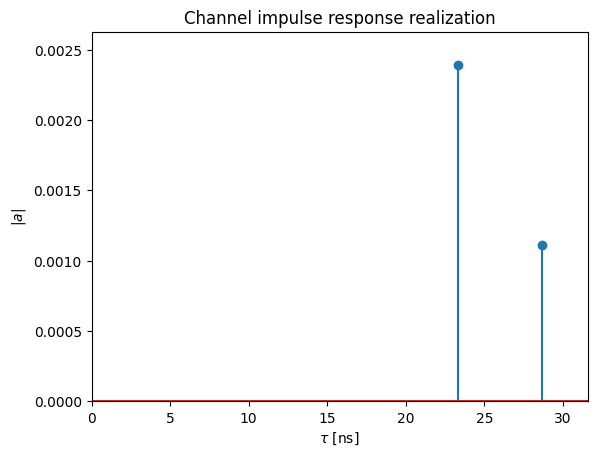

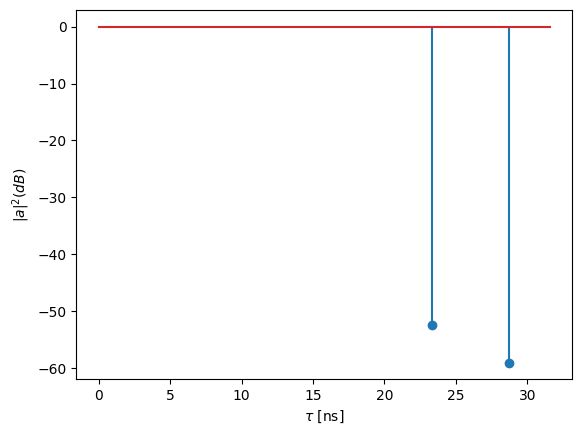

In [46]:
paths.normalize_delays = False
a, tau = paths.cir()
print("Shape of tau: ", tau.shape)

t = tau[0,0,0,:]/1e-9 # Scale to ns
a_abs = np.abs(a)[0,0,0,0,0,:,0]
a_max = np.max(a_abs)
# Add dummy entry at start/end for nicer figure
t = np.concatenate([(0.,), t, (np.max(t)*1.1,)])
a_abs = np.concatenate([(np.nan,), a_abs, (np.nan,)])

# And plot the CIR
plt.figure()
plt.title("Channel impulse response realization")

plt.stem(t, a_abs)
plt.xlim([0, np.max(t)])
plt.ylim([-2e-6, a_max*1.1])
plt.xlabel(r"$\tau$ [ns]")
plt.ylabel(r"$|a|$");

plt.figure()
plt.stem(t,20*np.log10(a_abs))
plt.xlabel(r"$\tau$ [ns]")
plt.ylabel(r"$|a|^2(dB)$");

In [47]:
print(a_abs)

[       nan 0.00238886 0.00111443        nan]


In [48]:
np.unique(a_abs)

array([0.00111443, 0.00238886,        nan])

In [49]:
print(f'{scene.objects}')

{'floor': <sionna.rt.scene_object.SceneObject object at 0x722fdf8dc9a0>}


In [50]:
scene.get("floor").radio_material.scattering_coefficient.numpy()

0.5

In [53]:
print(np.sum(a_abs[1:3]**2))

6.948592350418826e-06


In [54]:
print(type(a_abs))

<class 'numpy.ndarray'>
